# SIGNATE:[【練習問題】鋳造製品の欠陥検出](https://signate.jp/competitions/406)
こちら上記コンペにおいてResNet18を用いた実装コードとなります。

In [1]:
# for colab
# !nvidia-smi # GPUガチャ結果確認

In [2]:
# for colab
# !pip install torch_optimizer timm ttach
# !pip install wandb==0.10.7
# !pip install albumentations==0.4.6

In [3]:
import sys, os
import numpy as np
import pandas as pd
import shutil
import gc
import time
from datetime import datetime
from glob import glob
from tqdm import tqdm

from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
from sklearn.metrics import accuracy_score, f1_score

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SequentialSampler, RandomSampler
import torch_optimizer as optim
import timm
import ttach as tta

import cv2
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

# import wandb

In [4]:
def seed_everything(seed=42, is_tensorflow=False, is_torch=False, verbose=True):

    import os
    import random
    import numpy
    os.environ['PYTHONHASHSEED'] = str(seed) # os
    random.seed(seed) # random
    np.random.seed(seed) # numpy

    if is_tensorflow:
        import tensorflow as tf
        tf.random.set_seed(seed)
        os.environ['TF_DETERMINISTIC_OPS'] = '1'
        os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
        tf.config.threading.set_inter_op_parallelism_threads(1)
        tf.config.threading.set_intra_op_parallelism_threads(1)

    if is_torch:
        import torch
        torch.manual_seed(seed)
        torch.cuda.manual_seed(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False # True: 再現性なくなるが、計算速くなる False: 再現性が担保されるが、計算遅くなる

    if verbose:
        print(f'set random seed: {seed}')
        

class Logger:
    def __init__(self, log_path='./', verbose=True):
        self.log_path = log_path + 'log.txt'
        self.verbose = verbose

    def log(self, message):
        if self.verbose:
            print(message)
        with open(self.log_path, 'a+') as f:
            f.write(f'{message}\n')

# 対応データの読み込み

In [5]:
train = pd.read_csv('../data/raw/train.csv')
test = pd.read_csv('../data/raw/sample_submission.csv', names=['id', 'target'])

In [6]:
train.head()

,id,target
0,cast_def_0_335.jpeg,0
1,cast_def_0_323.jpeg,0
2,cast_def_0_61.jpeg,0
3,cast_def_0_163.jpeg,0
4,cast_def_0_175.jpeg,0


In [7]:
train.target.unique()

array([0, 1], dtype=int64)

In [8]:
test.head()

,id,target
0,19871.jpeg,0
1,29934.jpeg,0
2,39826.jpeg,0
3,49888.jpeg,0
4,59918.jpeg,0


# データセット、前処理の定義

In [9]:

class ImageDataset(Dataset):
    def __init__(self, df, image_dir, transforms=None, is_train=True):
        super().__init__()
        self.df = df
        self.image_dir = image_dir
        self.transforms = transforms
        self.is_train = is_train

    def __getitem__(self, index: int):
        image = self.load_image(index)
        label = self.df['target'][index] if self.is_train else -1
        label = torch.as_tensor(label, dtype=torch.int64)

        if self.transforms:
            image = self.transforms(**{"image": image})['image']

        return image, label

    def __len__(self) -> int:
        return len(self.df)

    def load_image(self, index):
        # read image data
        image_id = self.df['id'].values[index]
        image = cv2.imread(f'{self.image_dir}/{image_id}', cv2.COLOR_BGR2RGB).astype(np.float32)
        # image /= 255

        return image

In [10]:
# 画像augmentation
def get_transforms(phase: str, img_size=224):
    if phase == 'train':
        return A.Compose(
            [
                A.Resize(height=img_size, width=img_size, p=1.0),
                A.HorizontalFlip(p=0.5), # 水平反転
                A.VerticalFlip(p=0.5), # 垂直反転
                A.Rotate(limit=30, p=0.5), # 回転(30度以内)
                A.Normalize(mean=(0., 0., 0.), std=(1., 1., 1.)),
                ToTensorV2(p=1.0)
            ],
            p=1.0
        )
    else:
        return A.Compose(
            [
                A.Resize(height=img_size, width=img_size, p=1.0),
                A.Normalize(mean=(0., 0., 0.), std=(1., 1., 1.)),
                ToTensorV2(p=1.0)
            ],
            p=1.0
        )

## 動作確認

In [11]:
train_dataset = ImageDataset(df=train,
                             image_dir='../data/raw/train_data',
                             transforms=get_transforms('train'),
                             is_train=True)

In [12]:
print(train_dataset.__len__())
print(len(train_dataset))

250
250


In [13]:
train_dataset[0]

(tensor([[[0.6667, 0.6667, 0.6667,  ..., 0.5641, 0.5608, 0.5608],
          [0.6667, 0.6667, 0.6667,  ..., 0.5624, 0.5608, 0.5608],
          [0.6667, 0.6667, 0.6667,  ..., 0.5608, 0.5592, 0.5575],
          ...,
          [0.7255, 0.7255, 0.7255,  ..., 0.5928, 0.5980, 0.6033],
          [0.7255, 0.7255, 0.7255,  ..., 0.5928, 0.5980, 0.6033],
          [0.7255, 0.7255, 0.7255,  ..., 0.5928, 0.5980, 0.6033]],
 
         [[0.6667, 0.6667, 0.6667,  ..., 0.5641, 0.5608, 0.5608],
          [0.6667, 0.6667, 0.6667,  ..., 0.5624, 0.5608, 0.5608],
          [0.6667, 0.6667, 0.6667,  ..., 0.5608, 0.5592, 0.5575],
          ...,
          [0.7255, 0.7255, 0.7255,  ..., 0.5928, 0.5980, 0.6033],
          [0.7255, 0.7255, 0.7255,  ..., 0.5928, 0.5980, 0.6033],
          [0.7255, 0.7255, 0.7255,  ..., 0.5928, 0.5980, 0.6033]],
 
         [[0.6667, 0.6667, 0.6667,  ..., 0.5641, 0.5608, 0.5608],
          [0.6667, 0.6667, 0.6667,  ..., 0.5624, 0.5608, 0.5608],
          [0.6667, 0.6667, 0.6667,  ...,

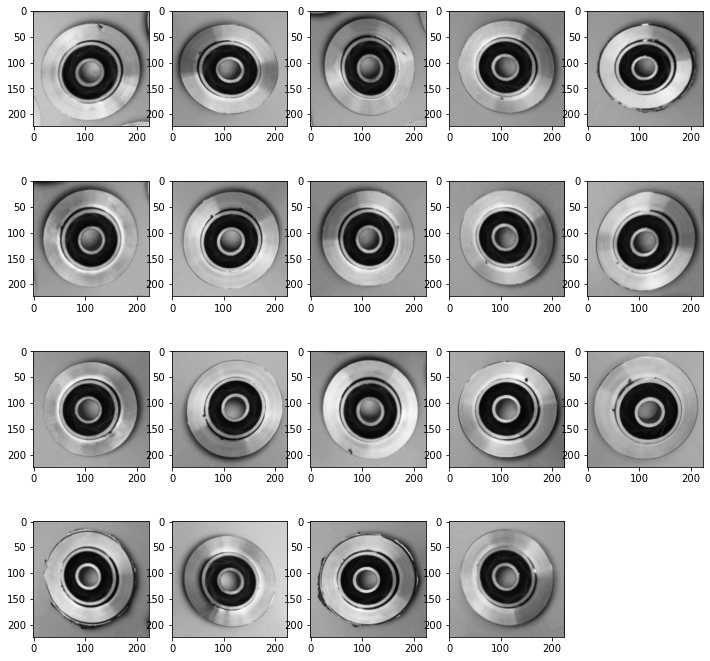

In [14]:
from matplotlib import pyplot as plt
plt.figure(figsize=(12, 12))
for i in range(1, 20):
    plt.subplot(4, 5, i)
    plt.imshow(train_dataset[i][0].numpy().transpose(1, 2, 0))

In [15]:
del train_dataset
gc.collect()

47656

# 学習にあたっての設定

In [16]:
class CFG:
    ##### notebook setting ####
    experiment = 2 # 実験番号
    seed = 42
    seed_everything(seed, is_torch=True)
    submit_file_name = f'{experiment}_20210904.csv' # 提出ファイル名

    ##### training setting ####
    img_size = 224
    out_dim = 2
    nfolds = 5
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    model_arch = "resnet18d" # timmにあるモデル指定
    pretrained = True
    num_workers = 0 # Windowsの人は0推奨
    batch_size = 16
    num_epochs = 20

    optim_params = dict(lr = 1e-3)

    class_weights = torch.tensor([1., 1.4]).to(device, dtype=torch.float) # データの分布見て適当に決めました
    loss_params = dict(pos_weight = class_weights)

    scheduler_params = dict(base_lr = 1e-4,
                            max_lr = 1e-3,
                            step_size_up = 10, 
                            cycle_momentum = False)

    folder = f'../data/experiments/exp{experiment}/model' # モデルの保存先指定
    verbose = True
    verbose_step = 1

set random seed: 42


# モデルの定義

In [17]:
class ImageModel(nn.Module):
    def __init__(self, config, in_chans=3):

        super(ImageModel, self).__init__()
        model_arch = config.model_arch
        out_dim = config.out_dim
        pretrained = config.pretrained
        self.backbone = timm.create_model(model_arch, pretrained=pretrained, in_chans=in_chans)

        if model_arch == 'resnet18d':
            self.n_features = self.backbone.fc.in_features
            self.backbone.fc = nn.Linear(self.n_features, out_dim)
        elif model_arch == 'resnet101d':
            self.n_features = self.backbone.fc.in_features
            self.backbone.fc = nn.Linear(self.n_features, out_dim)
        elif model_arch == 'tf_efficientnetv2_s_in21k':
            self.n_features = self.backbone.classifier.in_features
            self.backbone.classifier = nn.Linear(self.n_features, out_dim)

    def forward(self, x):
        output = self.backbone(x)
        output = F.log_softmax(output, dim=1)
        return output

# データローダーの定義

In [18]:
def ImageDataloader(df, image_dir, config, phase: str):
    assert phase == 'train' or 'test' or 'valid'
    if phase == 'test':
        dataset = ImageDataset(
            df=df,
            image_dir=image_dir,
            transforms=get_transforms(phase, img_size=config.img_size),
            is_train=False
        )
        return DataLoader(dataset,
                          batch_size=config.batch_size,
                          num_workers=config.num_workers,
                          drop_last=False,
                          shuffle=False,
                          pin_memory=True)

    elif phase == 'valid':
        dataset = ImageDataset(
            df=df,
            image_dir=image_dir,
            transforms=get_transforms(phase, img_size=config.img_size),
            is_train=True
        )
        return DataLoader(dataset,
                          batch_size=config.batch_size,
                          num_workers=config.num_workers,
                          drop_last=False,
                          shuffle=False,
                          pin_memory=True)

    else:
        dataset = ImageDataset(
            df=df,
            image_dir=image_dir,
            transforms=get_transforms(phase, img_size=config.img_size),
            is_train=True
        )
        return DataLoader(dataset,
                          batch_size=config.batch_size,
                          num_workers=config.num_workers,
                          drop_last=False,
                          shuffle=True,
                          pin_memory=True)

# Runnerの定義(これで訓練と推論を行います)
- train_one_epochで1epoch分の学習
- validationで1epoch分の検証
- fitが学習・検証結果の出力
- predictが推論

In [19]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [20]:
class Runner:

    def __init__(self, model, config,
                 OptimClass, LossClass, SchedulerClass,
                 WandbClass=None, fold=None):
        self.config = config
        self.epoch = 0
        self.base_dir = f'{config.folder}'
        if not os.path.exists(self.base_dir): os.makedirs(self.base_dir)
        self.log_path = f'{self.base_dir}/log.txt'
        self.best_summary_loss = 10 ** 5
        self.device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
        self.model = model
        self.model = self.model.to(self.device)
        self.fold = fold

        params = [p for p in self.model.parameters() if p.requires_grad]
        self.optimizer = OptimClass(params, **config.optim_params)
        self.loss_func = LossClass(**config.loss_params).to(self.device)
        self.scheduler = SchedulerClass(self.optimizer, **config.scheduler_params)
        self.log(f'\nRunner prepared. Device is {self.device}')

        if WandbClass:
            self.is_wandb = True
            self.wandb = WandbClass
            self.wandb.watch(self.model)
        else:
            self.is_wandb = False

    def fit(self, train_loader, valid_loader):
        self.log(f'**************** FOLD {self.fold} ****************')
        for e in range(self.config.num_epochs):
            if self.config.verbose:
                lr = self.optimizer.param_groups[0]['lr']
                timestamp = datetime.utcnow().isoformat()
                self.log(f'\n{timestamp}\nLR: {lr}')

            # ----------train------------
            t = time.time()
            summary_loss, acc = self.train_one_epoch(train_loader)
            self.log(
                f'[RESULT]: Train. Epoch: {self.epoch + 1}, summary_loss: {summary_loss.avg:.5f}, acc: {acc:.5f}, time: {(time.time() - t):.5f}'
            )
            self.save(f'{self.base_dir}/last-checkpoint-fold{self.fold}.bin')
            # --------------------------

            # --------validation--------
            t = time.time()
            summary_valloss, val_acc = self.validation(valid_loader)
            self.log(
                f'[RESULT]: Val. Epoch: {self.epoch + 1}, summary_loss: {summary_valloss.avg:.5f}, val_acc: {val_acc:.5f}, time: {(time.time() - t):.5f}'
            )
            # --------------------------

            if summary_valloss.avg < self.best_summary_loss:
                self.best_summary_loss = summary_valloss.avg
                self.model.eval()
                self.save(f'{self.base_dir}/best-checkpoint-fold{self.fold}-{str(self.epoch).zfill(3)}epoch.bin')
                for path in sorted(glob(f'{self.base_dir}/best-checkpoint-fold{self.fold}-*epoch.bin'))[:-2]: # save best 2 epochs
                    os.remove(path)

            # self.scheduler.step(metrics=summary_valloss.avg)
            self.scheduler.step()
            self.epoch += 1

    def predict(self, data_loader, is_tta=False, verbose=True):
        self.model.eval()
        y_pred = []

        if is_tta:
            # TTA(test time augmentation)の準備
            tta_transforms = tta.Compose(
                [
                    tta.HorizontalFlip(),
                    tta.VerticalFlip(),
                ]
            )
            tta_model = tta.ClassificationTTAWrapper(self.model, tta_transforms)

        t = time.time()
        for step, batch in enumerate(data_loader):
            if verbose:
                print(
                    f'pred Step {step + 1}/{len(data_loader)}, ' + \
                    f'time: {(time.time() - t):.5f}', end='\r'
                )
            with torch.no_grad():
                data, target = batch
                data = data.to(self.device, non_blocking=True)

                if is_tta:
                    output = tta_model(data)
                else:
                    output = self.model(data)

                # ------------Calculating accuracy---------------------
                y_pred += [ output.sigmoid().detach().cpu().numpy() ]

        y_pred = np.concatenate(y_pred)
        print(f'[DONE]: Fold{self.fold}')
        return y_pred

    def validation(self, val_loader):
        self.model.eval()
        summary_valloss = AverageMeter()
        y_pred = []
        y_true = []

        t = time.time()
        for step, (data, target) in enumerate(val_loader):
            if self.config.verbose:
                if step % self.config.verbose_step == 0:
                    print(
                        f'Val Step {step + 1}/{len(val_loader)}, ' + \
                        f'summary_loss: {summary_valloss.avg:.5f}, ' + \
                        f'time: {(time.time() - t):.5f}', end='\r'
                    )

            with torch.no_grad():
                data = data.to(self.device, non_blocking=True)
                target = target.to(self.device, non_blocking=True).long()
                output = self.model(data)

                # -------------Calculate validation losses------------
                target_oh = torch.nn.functional.one_hot(target, num_classes=self.config.out_dim).float()
                loss = self.loss_func(output, target_oh)
                loss_value = loss.item()

                # ------------Calculating accuracy---------------------
                y_pred += [ output.sigmoid().detach().cpu().numpy() ]
                y_true += [ target.detach().cpu().numpy() ]

                summary_valloss.update(loss_value, self.config.batch_size)

        y_pred = np.concatenate(y_pred)
        y_true = np.concatenate(y_true)
        acc = accuracy_score(y_true, np.argmax(y_pred, axis=1).astype('int'))

        if self.is_wandb:
            self.wandb.log({'val_loss': summary_valloss.avg, 'val_acc': acc})

        return summary_valloss, acc


    def train_one_epoch(self, train_loader):
        self.model.train()
        summary_loss = AverageMeter()
        y_pred = []
        y_true = []

        # --------------start--------------
        t = time.time()
        for step, (data, target) in enumerate(train_loader):
            if self.config.verbose:
                if step % self.config.verbose_step == 0:
                    print(
                        f'Train Step {step + 1}/{len(train_loader)}, ' + \
                        f'summary_loss: {summary_loss.avg:.5f}, ' + \
                        f'time: {(time.time() - t):.5f}', end='\r'
                    )

            # ------------Calculate training losses--------------
            data = data.to(self.device, non_blocking=True)
            target = target.to(self.device, non_blocking=True).long()

            output = self.model(data)

            target_oh = torch.nn.functional.one_hot(target, num_classes=self.config.out_dim).float()
            loss = self.loss_func(output, target_oh)
            loss_value = loss.item()

            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

            summary_loss.update(loss_value, self.config.batch_size)

            y_pred += [ output.sigmoid().detach().cpu().numpy() ]
            y_true += [ target.detach().cpu().numpy() ]

        y_pred = np.concatenate(y_pred)
        y_true = np.concatenate(y_true)
        acc = accuracy_score(y_true, np.argmax(y_pred, axis=1).astype('int'))

        if self.is_wandb:
            self.wandb.log({'loss': summary_loss.avg, 'acc': acc})

        return summary_loss, acc

    def save(self, path):
        self.model.eval()
        torch.save({
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'scheduler_state_dict': self.scheduler.state_dict(),
            'best_summary_loss': self.best_summary_loss,
            'epoch': self.epoch,
        }, path)

    def load(self, path):
        checkpoint = torch.load(path)
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        self.scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        self.best_summary_loss = checkpoint['best_summary_loss']
        self.epoch = checkpoint['epoch'] + 1

    def log(self, message):
        if self.config.verbose:
            print(message)
        with open(self.log_path, 'a+') as logger:
            logger.write(f'{message}\n')

# 学習

In [21]:
OptimClass = optim.RAdam
LossClass = nn.BCEWithLogitsLoss
SchedulerClass = torch.optim.lr_scheduler.CyclicLR

In [22]:
# training
skf = StratifiedKFold(n_splits=CFG.nfolds, shuffle=True, random_state=CFG.seed)
oof_pred = np.zeros(len(train), )
for i, (train_idx, valid_idx) in enumerate(skf.split(train['id'], train['target'])):
    df_train = train.iloc[train_idx].reset_index(drop=True)
    df_valid = train.iloc[valid_idx].reset_index(drop=True)
    # define model
    net = ImageModel(config=CFG)

    # data
    train_loader = ImageDataloader(df=df_train, 
                                    image_dir='../data/raw/train_data', 
                                    config=CFG,
                                    phase='train')
    val_loader = ImageDataloader(df=df_valid, 
                                 image_dir='../data/raw/train_data', 
                                 config=CFG,
                                 phase='valid')

    # train
    runner = Runner(model=net, config=CFG,
                    OptimClass=OptimClass, 
                    LossClass=LossClass, 
                    SchedulerClass=SchedulerClass,
                    fold=i)

    runner.fit(train_loader, val_loader)
    
    oof_pred[valid_idx] = np.argmax(runner.predict(val_loader, is_tta=False, verbose=False), axis=1)

    del train_loader, val_loader
    del net, runner
    gc.collect()
    torch.cuda.empty_cache()


Runner prepared. Device is cuda
**************** FOLD 0 ****************

2021-09-04T14:14:41.732402
LR: 0.0001
[RESULT]: Train. Epoch: 1, summary_loss: 0.85969, acc: 0.41000, time: 3.39000
[RESULT]: Val. Epoch: 1, summary_loss: 0.86676, val_acc: 0.60000, time: 0.22077

2021-09-04T14:14:45.705399
LR: 0.00019000000000000006
[RESULT]: Train. Epoch: 2, summary_loss: 0.84060, acc: 0.48000, time: 1.83230
[RESULT]: Val. Epoch: 2, summary_loss: 0.86253, val_acc: 0.56000, time: 0.23100

2021-09-04T14:14:48.147828
LR: 0.00028000000000000014
[RESULT]: Train. Epoch: 3, summary_loss: 0.77823, acc: 0.81500, time: 1.85126
[RESULT]: Val. Epoch: 3, summary_loss: 0.85187, val_acc: 0.72000, time: 0.24100

2021-09-04T14:14:50.635090
LR: 0.00036999999999999983
[RESULT]: Train. Epoch: 4, summary_loss: 0.70233, acc: 0.93500, time: 1.85085
[RESULT]: Val. Epoch: 4, summary_loss: 0.82875, val_acc: 0.68000, time: 0.22800

2021-09-04T14:14:53.107936
LR: 0.0004599999999999999
[RESULT]: Train. Epoch: 5, summary_l

[RESULT]: Train. Epoch: 19, summary_loss: 0.42378, acc: 0.98500, time: 1.86496
[RESULT]: Val. Epoch: 19, summary_loss: 0.42280, val_acc: 1.00000, time: 0.23324

2021-09-04T14:16:17.300990
LR: 0.00019000000000000006
[RESULT]: Train. Epoch: 20, summary_loss: 0.40501, acc: 1.00000, time: 1.88026
[RESULT]: Val. Epoch: 20, summary_loss: 0.42267, val_acc: 1.00000, time: 0.22108
[DONE]: Fold1

Runner prepared. Device is cuda
**************** FOLD 2 ****************

2021-09-04T14:16:20.094716
LR: 0.0001
[RESULT]: Train. Epoch: 1, summary_loss: 0.83783, acc: 0.52000, time: 1.86611
[RESULT]: Val. Epoch: 1, summary_loss: 0.93028, val_acc: 0.56000, time: 0.23700

2021-09-04T14:16:22.579823
LR: 0.00019000000000000006
[RESULT]: Train. Epoch: 2, summary_loss: 0.82090, acc: 0.63000, time: 1.87183
[RESULT]: Val. Epoch: 2, summary_loss: 0.91961, val_acc: 0.60000, time: 0.23900

2021-09-04T14:16:25.076654
LR: 0.00028000000000000014
[RESULT]: Train. Epoch: 3, summary_loss: 0.77347, acc: 0.80000, time: 1.

# 簡単な検証(混同行列だけでも見ておく)

Text(83.40000000000006, 0.5, 'truth')

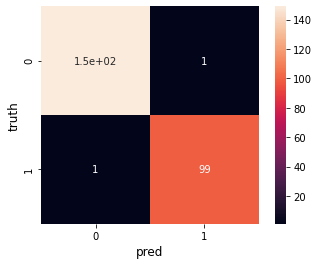

In [23]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(train['target'], oof_pred)
sns.heatmap(cm, square=True, cbar=True, annot=True)
plt.xlabel("pred", fontsize=12)
plt.ylabel("truth", fontsize=12)

# 推論と提出

In [24]:
test_loader = ImageDataloader(df=test, 
                              image_dir='../data/raw/test_data', 
                              config=CFG,
                              phase='test')

net = ImageModel(config=CFG)
runner = Runner(model=net, config=CFG,
                    OptimClass=OptimClass, 
                    LossClass=LossClass, 
                    SchedulerClass=SchedulerClass)


Runner prepared. Device is cuda


In [26]:
for i in range(CFG.nfolds):
    runner.load(path=f'{CFG.folder}/last-checkpoint-fold{i}.bin')

    if i == 0:
        pred = runner.predict(test_loader, is_tta=True)
    else:
        pred += runner.predict(test_loader, is_tta=True)
        
    torch.cuda.empty_cache()

[DONE]: FoldNoneime: 1.22159
[DONE]: FoldNoneime: 0.72889
[DONE]: FoldNoneime: 0.73500
[DONE]: FoldNoneime: 0.73546
[DONE]: FoldNoneime: 0.73600


In [27]:
test['target'] = np.argmax(pred, axis=1)
test.to_csv(f'../data/submit/{CFG.submit_file_name}', header=False, index=False)

# 以上使いまわしのコードになりますがResNet18での実装です(LB: 0.99)